In [19]:
import sys
sys.path.append('..')
from RDP_moment_accountant import compute_epsilon, get_noise_multiplier
import numpy as np

In [20]:
# Expected number of individuals (K)
EXPECTED_NUMBER_OF_INDIVIDUALS = 20.0

# Total number of individuals (|G|)
TOTAL_NUMBER_OF_INDIVIDUALS = 113.0

# Sampling Probability
SAMPLING_PROB = EXPECTED_NUMBER_OF_INDIVIDUALS / TOTAL_NUMBER_OF_INDIVIDUALS

# Number of rounds (T_r)
TOTAL_ITERS = 100

# Delta is constant (should not be modified!)
DELTA = 10 ** -5

# Target Epsilon is constant (should not be modified!)
EPS = 8

sigma = get_noise_multiplier(target_epsilon=EPS, 
                             target_delta=DELTA,
                             sample_rate=SAMPLING_PROB, 
                             steps=TOTAL_ITERS)
sigma


1.4068603515625

In [6]:
for k in [5, 10, 20, 50, 100]:
    SAMPLING_PROB = k / TOTAL_NUMBER_OF_INDIVIDUALS
    sigma = get_noise_multiplier(target_epsilon=EPS, 
                             target_delta=DELTA,
                             sample_rate=SAMPLING_PROB, 
                             steps=TOTAL_ITERS)
    print(sigma)

0.71044921875
0.93505859375
1.4068603515625
2.96630859375
5.673828125


In [8]:
K = 10
SAMPLING_PROB = K / TOTAL_NUMBER_OF_INDIVIDUALS
for total_iter in [10, 100, 500, 1000]:
    sigma = get_noise_multiplier(target_epsilon=EPS, 
                             target_delta=DELTA,
                             sample_rate=SAMPLING_PROB, 
                             steps=total_iter)
    print(sigma)

0.64300537109375
0.93505859375
1.488037109375
1.954345703125


In [21]:
import scanpy as sc
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch
import random
import numpy as np

In [22]:
import sys
sys.path.append("../src")

In [23]:
from factory import get_factory
from custom_parser import get_argparser, get_configparser

In [24]:
random_state=1000
random.seed(random_state)

In [25]:
home_dir='/home/c01teaf/CISPA-az6/llm_tg-2024/GRouNdGAN'
dataset='COVID_Haniffa21-GGpp-covid-privacy'
config=f'{home_dir}/configs/{dataset}/CrossVal_{random_state}/Stage1.cfg'

In [26]:
cfg_parser = get_configparser()
cfg_parser.read(config)

['/home/c01teaf/CISPA-az6/llm_tg-2024/GRouNdGAN/configs/COVID_Haniffa21-GGpp-covid-privacy/CrossVal_1000/Stage1.cfg']

In [35]:
data_path = f"{home_dir}/data/processed/COVID_Haniffa21-GGpp-covid/CrossVal_{random_state}/"
print(data_path)

/home/c01teaf/CISPA-az6/llm_tg-2024/GRouNdGAN/data/processed/COVID_Haniffa21-GGpp-covid/CrossVal_1000/


In [36]:
path_to_train = f"{data_path}/train.h5ad" # cfg.get("Data", "train")
anndata = sc.read_h5ad(path_to_train)

In [37]:
anndata.X = anndata.X.toarray()
anndata.X

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      , 43.572987,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [38]:
patient_ids = anndata.obs['patient_id'].unique()
len(patient_ids)

90

In [39]:
patient_ids

['newcastle004v2', 'MH9179825', 'newcastle49', 'AP5', 'MH8919327', ..., 'AP3', 'CV0231', 'newcastle21', 'CV0084', 'CV0201']
Length: 90
Categories (90, object): ['AP1', 'AP2', 'AP3', 'AP4', ..., 'newcastle21', 'newcastle21v2', 'newcastle49', 'newcastle59']

In [24]:
K=10
groups = np.array(patient_ids)
sampling_probability = np.divide(K, len(groups))
indices = np.array(groups)[np.random.choice(a=[False, True], 
                                            size=len(groups), 
                                            p=[1 - sampling_probability, sampling_probability])]
indices, len(indices)

(array(['MH8919332', 'CV0915', 'newcastle65', 'CV0902', 'CV0929', 'CV0939'],
       dtype=object),
 6)

In [27]:
k_poisson=[]
for i in range(100000):
    indices = np.array(groups)[np.random.choice(a=[False, True], 
                                            size=len(groups), 
                                            p=[1 - sampling_probability, sampling_probability])]
    k_poisson.append(len(indices))
    

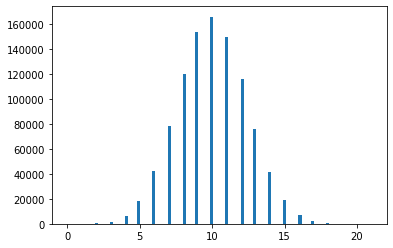

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(k_poisson, bins=20)

In [32]:
# groups = np.array(patient_ids)

# def poisson_sample(groups: np.array, p:float):
#     mask = torch.rand(len(groups)) < p
#     return groups[mask]


# sample = poisson_sample(groups, 0.1)
# print(sample)

['MH8919282' 'CV0944']


In [ ]:
# k_poisson=[]
# for i in range(1000000):
#     sample = poisson_sample(groups, sampling_probability)
#     k_poisson.append(sample)
# _ = plt.hist(k_poisson, bins=20)

['/home/c01teaf/CISPA-az6/llm_tg-2024/GRouNdGAN/configs/COVID_Haniffa21-GGpp/CrossVal_1000/Stage1.cfg']

In [40]:
valid_files = f'{data_path}/validation.h5ad'

In [60]:
eps = cfg_parser.getint("Privacy", "epsilon")
max_norm = cfg_parser.getint("Privacy", "max_norm")
delta = cfg_parser.getfloat("Privacy", "delta")
groups_per_round = cfg_parser.getint("Privacy", "groups_per_round")
total_round = cfg_parser.getint("Privacy", "total_round")
max_steps_per_round = cfg_parser.getint("Privacy", "max_steps_per_round")

max_steps_per_round = 10000
total_round = 100

In [61]:
groups = np.array(patient_ids)
sampling_probability = groups_per_round/len(groups) 

In [62]:
sigma = get_noise_multiplier(target_epsilon=eps, 
                             target_delta=delta,
                             sample_rate=sampling_probability, 
                             steps=total_round)
sigma

1.051025390625

In [ ]:
fac = get_factory(cfg_parser)
model = fac.get_cc()

# max_norm = 1 # Sensitivity
# # sigma = 1.4 # Noise multiplier
# std = max_norm * sigma 

# Tr = 5 # total round
# Tgd = 10 # total training inner round


for t in range(total_round):
    
    print(f"TRAINING ROUND: {t}")
    
#     sample_g = poisson_sample(groups, sampling_prob)
    sample_g = np.array(groups)[np.random.choice(a=[False, True], 
                                                size=len(groups), 
                                                p=[1 - sampling_probability, sampling_probability])]
    print(len(sample_g))
    
    # Initial Round Model 
    wt = parameters_to_vector([p.detach().clone() for p in model.gen.parameters()])
    
    Agg_Delta_W_clip = 0
    
    if len(sample_g) == 0:
        print('NO Group Sampled')
    else:
        for g in sample_g:
            print("--training")
            anndata_g = anndata[anndata.obs['patient_id'] == g]

            w0 = wt

            model.step = 0

            model.train(train_files=anndata_g,
                        valid_files=valid_files,
                        critic_iter=cfg_parser.getint("CC Training", "critic iterations"),
                        max_steps=max_steps_per_round,
                        c_lambda=cfg_parser.getfloat("CC Model", "lambda"),
                        beta1=cfg_parser.getfloat("CC Optimizer", "beta1"),
                        beta2=cfg_parser.getfloat("CC Optimizer", "beta2"),
                        gen_alpha_0=cfg_parser.getfloat(
                            "CC Learning Rate", "generator initial"
                        ),
                        gen_alpha_final=cfg_parser.getfloat(
                            "CC Learning Rate", "generator final"
                        ),
                        crit_alpha_0=cfg_parser.getfloat("CC Learning Rate", "critic initial"),
                        crit_alpha_final=cfg_parser.getfloat(
                            "CC Learning Rate", "critic final"
                        ),
                        checkpoint=None,
                        summary_freq=cfg_parser.getint("CC Logging", "summary frequency"),
                        plt_freq=cfg_parser.getint("CC Logging", "plot frequency"),
                        save_feq=cfg_parser.getint("CC Logging", "save frequency"),
                        output_dir=f'./model_{g}.pt',
                )

            w1 = parameters_to_vector([p.detach().clone() for p in model.gen.parameters()])

            delta_w = w1 - w0 

            l2 = delta_w.norm().item()

            print(Agg_Delta_W_clip)

            # Clip
            denominator = max(1, l2/max_norm)
            delta_w_clip = delta_w/denominator

            Agg_Delta_W_clip += delta_w_clip
        
    # Aggregate and add noise
    noise_vec = torch.normal(
                    mean=0.0,
                    std=std,
                    size=Agg_Delta_W_clip.shape,
                    device=Agg_Delta_W_clip.device,
                    dtype=Agg_Delta_W_clip.dtype
                )
#     noise_vec  = torch.randn_like(Agg_Delta_W_clip) * std
    noisy_agg = 1/K * (Agg_Delta_W_clip + noise_vec)
    
    print("Adding Noise:")
    # Final Round Model
    wT = wt + noisy_agg
    vector_to_parameters(wT, model.gen.parameters())

TRAINING ROUND: 0
9
--training
done training step 0
done training step 1
done training step 2
done training step 3
done training step 4
done training step 5
done training step 6
done training step 7
done training step 8
done training step 9
done training step 10
done training step 11
done training step 12
done training step 13
done training step 14
done training step 15
done training step 16
done training step 17
done training step 18
done training step 19
done training step 20
done training step 21
done training step 22
done training step 23
done training step 24
done training step 25
done training step 26
done training step 27
done training step 28
done training step 29
done training step 30
done training step 31
done training step 32
done training step 33
done training step 34
done training step 35
done training step 36
done training step 37
done training step 38
done training step 39
done training step 40
done training step 41
done training step 42
done training step 43
done traini

done training step 360
done training step 361
done training step 362
done training step 363
done training step 364
done training step 365
done training step 366
done training step 367
done training step 368
done training step 369
done training step 370
done training step 371
done training step 372
done training step 373
done training step 374
done training step 375
done training step 376
done training step 377
done training step 378
done training step 379
done training step 380
done training step 381
done training step 382
done training step 383
done training step 384
done training step 385
done training step 386
done training step 387
done training step 388
done training step 389
done training step 390
done training step 391
done training step 392
done training step 393
done training step 394
done training step 395
done training step 396
done training step 397
done training step 398
done training step 399
done training step 400
done training step 401
done training step 402
done traini

done training step 717
done training step 718
done training step 719
done training step 720
done training step 721
done training step 722
done training step 723
done training step 724
done training step 725
done training step 726
done training step 727
done training step 728
done training step 729
done training step 730
done training step 731
done training step 732
done training step 733
done training step 734
done training step 735
done training step 736
done training step 737
done training step 738
done training step 739
done training step 740
done training step 741
done training step 742
done training step 743
done training step 744
done training step 745
done training step 746
done training step 747
done training step 748
done training step 749
done training step 750
done training step 751
done training step 752
done training step 753
done training step 754
done training step 755
done training step 756
done training step 757
done training step 758
done training step 759
done traini

done training step 1071
done training step 1072
done training step 1073
done training step 1074
done training step 1075
done training step 1076
done training step 1077
done training step 1078
done training step 1079
done training step 1080
done training step 1081
done training step 1082
done training step 1083
done training step 1084
done training step 1085
done training step 1086
done training step 1087
done training step 1088
done training step 1089
done training step 1090
done training step 1091
done training step 1092
done training step 1093
done training step 1094
done training step 1095
done training step 1096
done training step 1097
done training step 1098
done training step 1099
done training step 1100
done training step 1101
done training step 1102
done training step 1103
done training step 1104
done training step 1105
done training step 1106
done training step 1107
done training step 1108
done training step 1109
done training step 1110
done training step 1111
done training st

done training step 1413
done training step 1414
done training step 1415
done training step 1416
done training step 1417
done training step 1418
done training step 1419
done training step 1420
done training step 1421
done training step 1422
done training step 1423
done training step 1424
done training step 1425
done training step 1426
done training step 1427
done training step 1428
done training step 1429
done training step 1430
done training step 1431
done training step 1432
done training step 1433
done training step 1434
done training step 1435
done training step 1436
done training step 1437
done training step 1438
done training step 1439
done training step 1440
done training step 1441
done training step 1442
done training step 1443
done training step 1444
done training step 1445
done training step 1446
done training step 1447
done training step 1448
done training step 1449
done training step 1450
done training step 1451
done training step 1452
done training step 1453
done training st

done training step 1755
done training step 1756
done training step 1757
done training step 1758
done training step 1759
done training step 1760
done training step 1761
done training step 1762
done training step 1763
done training step 1764
done training step 1765
done training step 1766
done training step 1767
done training step 1768
done training step 1769
done training step 1770
done training step 1771
done training step 1772
done training step 1773
done training step 1774
done training step 1775
done training step 1776
done training step 1777
done training step 1778
done training step 1779
done training step 1780
done training step 1781
done training step 1782
done training step 1783
done training step 1784
done training step 1785
done training step 1786
done training step 1787
done training step 1788
done training step 1789
done training step 1790
done training step 1791
done training step 1792
done training step 1793
done training step 1794
done training step 1795
done training st

done training step 2097
done training step 2098
done training step 2099
done training step 2100
done training step 2101
done training step 2102
done training step 2103
done training step 2104
done training step 2105
done training step 2106
done training step 2107
done training step 2108
done training step 2109
done training step 2110
done training step 2111
done training step 2112
done training step 2113
done training step 2114
done training step 2115
done training step 2116
done training step 2117
done training step 2118
done training step 2119
done training step 2120
done training step 2121
done training step 2122
done training step 2123
done training step 2124
done training step 2125
done training step 2126
done training step 2127
done training step 2128
done training step 2129
done training step 2130
done training step 2131
done training step 2132
done training step 2133
done training step 2134
done training step 2135
done training step 2136
done training step 2137
done training st

done training step 2439
done training step 2440
done training step 2441
done training step 2442
done training step 2443
done training step 2444
done training step 2445
done training step 2446
done training step 2447
done training step 2448
done training step 2449
done training step 2450
done training step 2451
done training step 2452
done training step 2453
done training step 2454
done training step 2455
done training step 2456
done training step 2457
done training step 2458
done training step 2459
done training step 2460
done training step 2461
done training step 2462
done training step 2463
done training step 2464
done training step 2465
done training step 2466
done training step 2467
done training step 2468
done training step 2469
done training step 2470
done training step 2471
done training step 2472
done training step 2473
done training step 2474
done training step 2475
done training step 2476
done training step 2477
done training step 2478
done training step 2479
done training st

done training step 2781
done training step 2782
done training step 2783
done training step 2784
done training step 2785
done training step 2786
done training step 2787
done training step 2788
done training step 2789
done training step 2790
done training step 2791
done training step 2792
done training step 2793
done training step 2794
done training step 2795
done training step 2796
done training step 2797
done training step 2798
done training step 2799
done training step 2800
done training step 2801
done training step 2802
done training step 2803
done training step 2804
done training step 2805
done training step 2806
done training step 2807
done training step 2808
done training step 2809
done training step 2810
done training step 2811
done training step 2812
done training step 2813
done training step 2814
done training step 2815
done training step 2816
done training step 2817
done training step 2818
done training step 2819
done training step 2820
done training step 2821
done training st

done training step 3123
done training step 3124
done training step 3125
done training step 3126
done training step 3127
done training step 3128
done training step 3129
done training step 3130
done training step 3131
done training step 3132
done training step 3133
done training step 3134
done training step 3135
done training step 3136
done training step 3137
done training step 3138
done training step 3139
done training step 3140
done training step 3141
done training step 3142
done training step 3143
done training step 3144
done training step 3145
done training step 3146
done training step 3147
done training step 3148
done training step 3149
done training step 3150
done training step 3151
done training step 3152
done training step 3153
done training step 3154
done training step 3155
done training step 3156
done training step 3157
done training step 3158
done training step 3159
done training step 3160
done training step 3161
done training step 3162
done training step 3163
done training st

done training step 3465
done training step 3466
done training step 3467
done training step 3468
done training step 3469
done training step 3470
done training step 3471
done training step 3472
done training step 3473
done training step 3474
done training step 3475
done training step 3476
done training step 3477
done training step 3478
done training step 3479
done training step 3480
done training step 3481
done training step 3482
done training step 3483
done training step 3484
done training step 3485
done training step 3486
done training step 3487
done training step 3488
done training step 3489
done training step 3490
done training step 3491
done training step 3492
done training step 3493
done training step 3494
done training step 3495
done training step 3496
done training step 3497
done training step 3498
done training step 3499
done training step 3500
done training step 3501
done training step 3502
done training step 3503
done training step 3504
done training step 3505
done training st

done training step 3807
done training step 3808
done training step 3809
done training step 3810
done training step 3811
done training step 3812
done training step 3813
done training step 3814
done training step 3815
done training step 3816
done training step 3817
done training step 3818
done training step 3819
done training step 3820
done training step 3821
done training step 3822
done training step 3823
done training step 3824
done training step 3825
done training step 3826
done training step 3827
done training step 3828
done training step 3829
done training step 3830
done training step 3831
done training step 3832
done training step 3833
done training step 3834
done training step 3835
done training step 3836
done training step 3837
done training step 3838
done training step 3839
done training step 3840
done training step 3841
done training step 3842
done training step 3843
done training step 3844
done training step 3845
done training step 3846
done training step 3847
done training st

done training step 4149
done training step 4150
done training step 4151
done training step 4152
done training step 4153
done training step 4154
done training step 4155
done training step 4156
done training step 4157
done training step 4158
done training step 4159
done training step 4160
done training step 4161
done training step 4162
done training step 4163
done training step 4164
done training step 4165
done training step 4166
done training step 4167
done training step 4168
done training step 4169
done training step 4170
done training step 4171
done training step 4172
done training step 4173
done training step 4174
done training step 4175
done training step 4176
done training step 4177
done training step 4178
done training step 4179
done training step 4180
done training step 4181
done training step 4182
done training step 4183
done training step 4184
done training step 4185
done training step 4186
done training step 4187
done training step 4188
done training step 4189
done training st

done training step 4491
done training step 4492
done training step 4493
done training step 4494
done training step 4495
done training step 4496
done training step 4497
done training step 4498
done training step 4499
done training step 4500
done training step 4501
done training step 4502
done training step 4503
done training step 4504
done training step 4505
done training step 4506
done training step 4507
done training step 4508
done training step 4509
done training step 4510
done training step 4511
done training step 4512
done training step 4513
done training step 4514
done training step 4515
done training step 4516
done training step 4517
done training step 4518
done training step 4519
done training step 4520
done training step 4521
done training step 4522
done training step 4523
done training step 4524
done training step 4525
done training step 4526
done training step 4527
done training step 4528
done training step 4529
done training step 4530
done training step 4531
done training st

done training step 4833
done training step 4834
done training step 4835
done training step 4836
done training step 4837
done training step 4838
done training step 4839
done training step 4840
done training step 4841
done training step 4842
done training step 4843
done training step 4844
done training step 4845
done training step 4846
done training step 4847
done training step 4848
done training step 4849
done training step 4850
done training step 4851
done training step 4852
done training step 4853
done training step 4854
done training step 4855
done training step 4856
done training step 4857
done training step 4858
done training step 4859
done training step 4860
done training step 4861
done training step 4862
done training step 4863
done training step 4864
done training step 4865
done training step 4866
done training step 4867
done training step 4868
done training step 4869
done training step 4870
done training step 4871
done training step 4872
done training step 4873
done training st

done training step 5175
done training step 5176
done training step 5177
done training step 5178
done training step 5179
done training step 5180
done training step 5181
done training step 5182
done training step 5183
done training step 5184
done training step 5185
done training step 5186
done training step 5187
done training step 5188
done training step 5189
done training step 5190
done training step 5191
done training step 5192
done training step 5193
done training step 5194
done training step 5195
done training step 5196
done training step 5197
done training step 5198
done training step 5199
done training step 5200
done training step 5201
done training step 5202
done training step 5203
done training step 5204
done training step 5205
done training step 5206
done training step 5207
done training step 5208
done training step 5209
done training step 5210
done training step 5211
done training step 5212
done training step 5213
done training step 5214
done training step 5215
done training st

done training step 5517
done training step 5518
done training step 5519
done training step 5520
done training step 5521
done training step 5522
done training step 5523
done training step 5524
done training step 5525
done training step 5526
done training step 5527
done training step 5528
done training step 5529
done training step 5530
done training step 5531
done training step 5532
done training step 5533
done training step 5534
done training step 5535
done training step 5536
done training step 5537
done training step 5538
done training step 5539
done training step 5540
done training step 5541
done training step 5542
done training step 5543
done training step 5544
done training step 5545
done training step 5546
done training step 5547
done training step 5548
done training step 5549
done training step 5550
done training step 5551
done training step 5552
done training step 5553
done training step 5554
done training step 5555
done training step 5556
done training step 5557
done training st

done training step 5859
done training step 5860
done training step 5861
done training step 5862
done training step 5863
done training step 5864
done training step 5865
done training step 5866
done training step 5867
done training step 5868
done training step 5869
done training step 5870
done training step 5871
done training step 5872
done training step 5873
done training step 5874
done training step 5875
done training step 5876
done training step 5877
done training step 5878
done training step 5879
done training step 5880
done training step 5881
done training step 5882
done training step 5883
done training step 5884
done training step 5885
done training step 5886
done training step 5887
done training step 5888
done training step 5889
done training step 5890
done training step 5891
done training step 5892
done training step 5893
done training step 5894
done training step 5895
done training step 5896
done training step 5897
done training step 5898
done training step 5899
done training st

done training step 6201
done training step 6202
done training step 6203
done training step 6204
done training step 6205
done training step 6206
done training step 6207
done training step 6208
done training step 6209
done training step 6210
done training step 6211
done training step 6212
done training step 6213
done training step 6214
done training step 6215
done training step 6216
done training step 6217
done training step 6218
done training step 6219
done training step 6220
done training step 6221
done training step 6222
done training step 6223
done training step 6224
done training step 6225
done training step 6226
done training step 6227
done training step 6228
done training step 6229
done training step 6230
done training step 6231
done training step 6232
done training step 6233
done training step 6234
done training step 6235
done training step 6236
done training step 6237
done training step 6238
done training step 6239
done training step 6240
done training step 6241
done training st

done training step 6543
done training step 6544
done training step 6545
done training step 6546
done training step 6547
done training step 6548
done training step 6549
done training step 6550
done training step 6551
done training step 6552
done training step 6553
done training step 6554
done training step 6555
done training step 6556
done training step 6557
done training step 6558
done training step 6559
done training step 6560
done training step 6561
done training step 6562
done training step 6563
done training step 6564
done training step 6565
done training step 6566
done training step 6567
done training step 6568
done training step 6569
done training step 6570
done training step 6571
done training step 6572
done training step 6573
done training step 6574
done training step 6575
done training step 6576
done training step 6577
done training step 6578
done training step 6579
done training step 6580
done training step 6581
done training step 6582
done training step 6583
done training st

done training step 6885
done training step 6886
done training step 6887
done training step 6888
done training step 6889
done training step 6890
done training step 6891
done training step 6892
done training step 6893
done training step 6894
done training step 6895
done training step 6896
done training step 6897
done training step 6898
done training step 6899
done training step 6900
done training step 6901
done training step 6902
done training step 6903
done training step 6904
done training step 6905
done training step 6906
done training step 6907
done training step 6908
done training step 6909
done training step 6910
done training step 6911
done training step 6912
done training step 6913
done training step 6914
done training step 6915
done training step 6916
done training step 6917
done training step 6918
done training step 6919
done training step 6920
done training step 6921
done training step 6922
done training step 6923
done training step 6924
done training step 6925
done training st

done training step 7227
done training step 7228
done training step 7229
done training step 7230
done training step 7231
done training step 7232
done training step 7233
done training step 7234
done training step 7235
done training step 7236
done training step 7237
done training step 7238
done training step 7239
done training step 7240
done training step 7241
done training step 7242
done training step 7243
done training step 7244
done training step 7245
done training step 7246
done training step 7247
done training step 7248
done training step 7249
done training step 7250
done training step 7251
done training step 7252
done training step 7253
done training step 7254
done training step 7255
done training step 7256
done training step 7257
done training step 7258
done training step 7259
done training step 7260
done training step 7261
done training step 7262
done training step 7263
done training step 7264
done training step 7265
done training step 7266
done training step 7267
done training st

done training step 7569
done training step 7570
done training step 7571
done training step 7572
done training step 7573
done training step 7574
done training step 7575
done training step 7576
done training step 7577
done training step 7578
done training step 7579
done training step 7580
done training step 7581
done training step 7582
done training step 7583
done training step 7584
done training step 7585
done training step 7586
done training step 7587
done training step 7588
done training step 7589
done training step 7590
done training step 7591
done training step 7592
done training step 7593
done training step 7594
done training step 7595
done training step 7596
done training step 7597
done training step 7598
done training step 7599
done training step 7600
done training step 7601
done training step 7602
done training step 7603
done training step 7604
done training step 7605
done training step 7606
done training step 7607
done training step 7608
done training step 7609
done training st

done training step 7911
done training step 7912
done training step 7913
done training step 7914
done training step 7915
done training step 7916
done training step 7917
done training step 7918
done training step 7919
done training step 7920
done training step 7921
done training step 7922
done training step 7923
done training step 7924
done training step 7925
done training step 7926
done training step 7927
done training step 7928
done training step 7929
done training step 7930
done training step 7931
done training step 7932
done training step 7933
done training step 7934
done training step 7935
done training step 7936
done training step 7937
done training step 7938
done training step 7939
done training step 7940
done training step 7941
done training step 7942
done training step 7943
done training step 7944
done training step 7945
done training step 7946
done training step 7947
done training step 7948
done training step 7949
done training step 7950
done training step 7951
done training st

done training step 8257
done training step 8258
done training step 8259
done training step 8260
done training step 8261
done training step 8262
done training step 8263
done training step 8264
done training step 8265
done training step 8266
done training step 8267
done training step 8268
done training step 8269
done training step 8270
done training step 8271
done training step 8272
done training step 8273
done training step 8274
done training step 8275
done training step 8276
done training step 8277
done training step 8278
done training step 8279
done training step 8280
done training step 8281
done training step 8282
done training step 8283
done training step 8284
done training step 8285
done training step 8286
done training step 8287
done training step 8288
done training step 8289
done training step 8290
done training step 8291
done training step 8292
done training step 8293
done training step 8294
done training step 8295
done training step 8296
done training step 8297
done training st

In [ ]:
model.generate_cells(10)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
_, valid_loader = model._get_loaders(valid_files, valid_files)

In [ ]:
fake_cells = model.generate_cells(len(valid_loader.dataset))
valid_cells, _ = next(iter(valid_loader))

embedded_cells = TSNE().fit_transform(
    np.concatenate((valid_cells, fake_cells), axis=0)
)

real_embedding = embedded_cells[0 : valid_cells.shape[0], :]
fake_embedding = embedded_cells[valid_cells.shape[0] :, :]

plt.clf()
fig = plt.figure()

plt.scatter(
    real_embedding[:, 0],
    real_embedding[:, 1],
    c="blue",
    label="real",
    alpha=0.5,
)

plt.scatter(
    fake_embedding[:, 0],
    fake_embedding[:, 1],
    c="red",
    label="fake",
    alpha=0.5,
)

plt.grid(True)
plt.legend(
    loc="lower left", numpoints=1, ncol=2, fontsize=8, bbox_to_anchor=(0, 0)
)


In [56]:
anndata.var_names

Index(['ABCC3', 'ABLIM3', 'ABO', 'AC002070.1', 'AC005381.1', 'AC006146.1',
       'AC006305.1', 'AC007938.1', 'AC007998.3', 'AC008278.1',
       ...
       'WDR11-AS1', 'WEE2', 'WFDC1', 'XCL1', 'XCL2', 'XIRP2', 'XK', 'Z69666.1',
       'ZNF185', 'ZNF385B'],
      dtype='object', length=1000)